# 23_04_25_05_erythroid_lineage_下游分析1_批次整合方法对比

In [1]:
import anndata as ad
import scanpy as sc
import scvelo as scv

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## 1. 读取原始数据

In [2]:
# 红系成熟部分
adata = scv.read("/mnt/h/F_bak/PyCode/xijing/notebook/data/Gastrulation/erythroid_lineage.h5ad")
# sc.pp.subsample(adata, n_obs=500)
# 这里就不能在随机抽样了，为了与之前抽样作比较，这里需要与之前的细胞完全一致
adata2 = scv.read("./tmp/erythroid_lineage2/adata/adata.h5ad")
adata = adata[list(adata2.obs.index)].copy()
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [3]:
adata_bak = adata.copy()

## 2. 使用scib包保存批次矫正处理后的结果

1. scib包和scvelo包会冲突，所有这里需要再scib环境下保存本节的结果，然后再使用velovi-env环境查看速率结果

2. 批次矫正处理函数定义：
    - U与S分别做整合
        - 参考：/mnt/h/F_bak/Python进阶/scRNA/LatentVelo/LatentVelo-main/latentvelo/tools/batch_correction.py，其实它也是参考了 https://www.hansenlab.org/velocity_batch。
        - 但是好像没有经过合适的预处理，需要自己做
    - U与S按照比例做整合，学习LatentVelo的提到的整合方式：
        - 这里单独创建一个conda环境，使用scib的scgen，使用更加方便: https://scib.readthedocs.io/en/latest/api/scib.integration.scgen.html#scib.integration.scgen
        - scgen的预处理参考GitHub, notebook: https://github.com/theislab/scgen , https://scgen.readthedocs.io/en/stable/tutorials/scgen_batch_removal.html
    - 数据变化部分可以选择是scanpy还是scvelo做

In [4]:
import numpy as np
import anndata as ad

import scib

def transform_adata(adata, transform_method="scvelo"):
    if transform_method=="scanpy":
        # TODO: 使用scanpy分别预处理两个矩阵
        adata_spliced = ad.AnnData(adata.layers["spliced"])
        adata_spliced.var.index = adata.var.index
        adata_unspliced = ad.AnnData(adata.layers["unspliced"])
        adata_unspliced.var.index = adata.var.index

        sc.pp.normalize_total(adata_spliced)
        sc.pp.log1p(adata_spliced)
        sc.pp.normalize_total(adata_unspliced)
        sc.pp.log1p(adata_unspliced)
        
        sc.pp.highly_variable_genes(adata_spliced, n_top_genes=2000) # 以spliced的高变化基因为准
        hvg_gene_list = list(adata_spliced.var[adata_spliced.var.highly_variable].index) 

        adata = adata[:, hvg_gene_list]
        adata.layers["spliced"] = adata_spliced[:, hvg_gene_list].X
        adata.layers["unspliced"] = adata_unspliced[:, hvg_gene_list].X
        return adata
    else:
        # 直接调用scvelo的方法，就不用分开做了
        scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
    return adata # 引用参数指针变化了，这里必须返回


def review_preprocess(adata, batch_key,
                    cluster_key,
                    save=None,
                    transform_method="scvelo",
                    batch_removal_method="scgen",
                    epochs=10):
    # review论文中分别对S，U批次矫正

    # 执行数据转换
    adata = transform_adata(adata, transform_method=transform_method)

    # 提出数据变化后的矩阵构造对象
    adata_spliced = ad.AnnData(adata.layers["spliced"], obs=adata.obs[[batch_key, cluster_key]])
    adata_unspliced = ad.AnnData(adata.layers["unspliced"], obs=adata.obs[[batch_key, cluster_key]])

    # 执行矫正
    if batch_removal_method=="scgen":
        corrected_adata_spliced = scib.ig.scgen(adata_spliced, batch=batch_key, cell_type=cluster_key, epochs=epochs)
        corrected_adata_unspliced = scib.ig.scgen(adata_unspliced, batch=batch_key, cell_type=cluster_key, epochs=epochs)
    else:
        pass
        # TODO: 其他矫正方法
        # corrected_adata_spliced = scib.ig.harmony(adata_spliced, batch=batch_key)
        # corrected_adata_unspliced = scib.ig.harmony(adata_unspliced, batch=batch_key)

    # 保存到adata里
    corrected_S = corrected_adata_spliced.X
    corrected_U = corrected_adata_unspliced.X
    adata.X = corrected_S
    adata.layers["spliced"] = corrected_S
    adata.layers["unspliced"] = corrected_U

    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    if save:
        adata.write(save)

    return adata


def latentvelo_preprocess(adata, batch_key,
                          cluster_key,
                          save=None,
                          transform_method="scvelo",
                          batch_removal_method="scgen",
                          epochs=10):
    # latentvelo论文中考虑S，U相对数量比例的批次矫正方法
    
    # 执行数据转换
    adata = transform_adata(adata, transform_method=transform_method)

    # 计算比率关系矩阵
    M = np.array(adata.layers["spliced"].todense() + adata.layers["unspliced"].todense())
    masked_M = (M>0)*M + (M==0)
    R = np.array(adata.layers["spliced"].todense())/masked_M

    adata_sum = ad.AnnData(M, obs=adata.obs[[batch_key, cluster_key]])

    # 执行矫正
    if batch_removal_method=="scgen":
        corrected_adata_sum = scib.ig.scgen(adata_sum, batch=batch_key, cell_type=cluster_key, epochs=epochs)
    else:
        pass
        # TODO: 其他矫正方法
        # corrected_adata_sum = scib.ig.harmony(adata_sum, batch=batch_key)

    # 恢复并保存到adata里
    corrected_M = corrected_adata_sum.X
    corrected_S = corrected_M * R
    corrected_U = corrected_M * (1-R)
    adata.X = corrected_S
    adata.layers["spliced"] = corrected_S
    adata.layers["unspliced"] = corrected_U

    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

    if save:
        adata.write(save)

3. 批次矫正函数执行

In [5]:
# adata = adata_bak.copy()
# corrected_tmp_adata_filename = "./tmp/corrected_erythroid_lineage_tmp_review_scanpy.h5ad"
# review_preprocess(adata, batch_key, cluster_key, save=corrected_tmp_adata_filename, transform_method="scanpy")

/usr/local/conda/envs/scib/lib/python3.8/site-packages/lightning_fabric/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/usr/local/conda/envs/scib/lib/python3.8/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
Global seed set to 0
/usr/local/conda/envs/scib/lib/python3.8/site-packages/scvi/data/_utils.py:

Epoch 10/10: 100%|██████████| 10/10 [00:07<00:00,  1.82it/s, loss=86.4, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s, loss=86.4, v_num=1]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/conda/envs/scib/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/usr/local/conda/envs/scib/lib/python3.8/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  1.96it/s, loss=17.2, v_num=1]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s, loss=17.2, v_num=1]
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/usr/local/conda/envs/scib/lib/python3.8/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(
/usr/local/conda/envs/scib/lib/python3.8/site-packages/scvi/data/_utils.py:172: UserWarning: Category 0 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  warnings.warn(


computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


AnnData object with n_obs × n_vars = 500 × 2000
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [6]:
# adata = adata_bak.copy()
# corrected_tmp_adata_filename = "./tmp/corrected_erythroid_lineage_tmp_review_scvelo.h5ad"
# review_preprocess(adata, batch_key, cluster_key, save=corrected_tmp_adata_filename, transform_method="scvelo")

In [7]:
# adata = adata_bak.copy()
# corrected_tmp_adata_filename = "./tmp/corrected_erythroid_lineage_tmp_latentvelo_scanpy.h5ad"
# latentvelo_preprocess(adata, batch_key, cluster_key, save=corrected_tmp_adata_filename, transform_method="scanpy")

In [8]:
# adata = adata_bak.copy()
# corrected_tmp_adata_filename = "./tmp/corrected_erythroid_lineage_tmp_latentvelo_scvelo.h5ad"
# latentvelo_preprocess(adata, batch_key, cluster_key, save=corrected_tmp_adata_filename, transform_method="scvelo")

## 3. 查看批次矫正的速率结果

1. scvelo的各种模式绘图总体

In [9]:
import matplotlib.pyplot as plt

def plot_scvelo_all_mode(adata, cluster_key, mode_list=["deterministic", "dynamical", "stochastic"]):
    n = len(mode_list)
    adata_bak = adata.copy()
    fig, ax = plt.subplots(1,n, figsize=(5*n+5,5))
    
    for i in range(n):
        mode = mode_list[i]
        adata = adata_bak.copy()
        print("===== %s ====="%mode)
        if mode == "dynamical":
            scv.tl.recover_dynamics(adata)
        scv.tl.velocity(adata, mode=mode)
        scv.tl.velocity_graph(adata)
        scv.pl.velocity_embedding_stream(adata, color=cluster_key, ax=ax[i], title=mode, show=False)
        
    plt.show()

2. 执行绘图

===== deterministic =====
computing velocities
The correlation threshold has been reduced to -24881.5422.
Please be cautious when interpreting results.
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== dynamical =====
recovering dynamics (using 1/12 cores)
The correlation threshold has been reduced to -11941.2414.
Please be cautious when interpreting results.


  0%|          | 0/400 [00:00<?, ?gene/s]

    finished (0:01:21) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== stochastic =====
computing velocities
The correlation threshold has been reduced to -24881.5422.
Please be cautious when interpreting results.
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


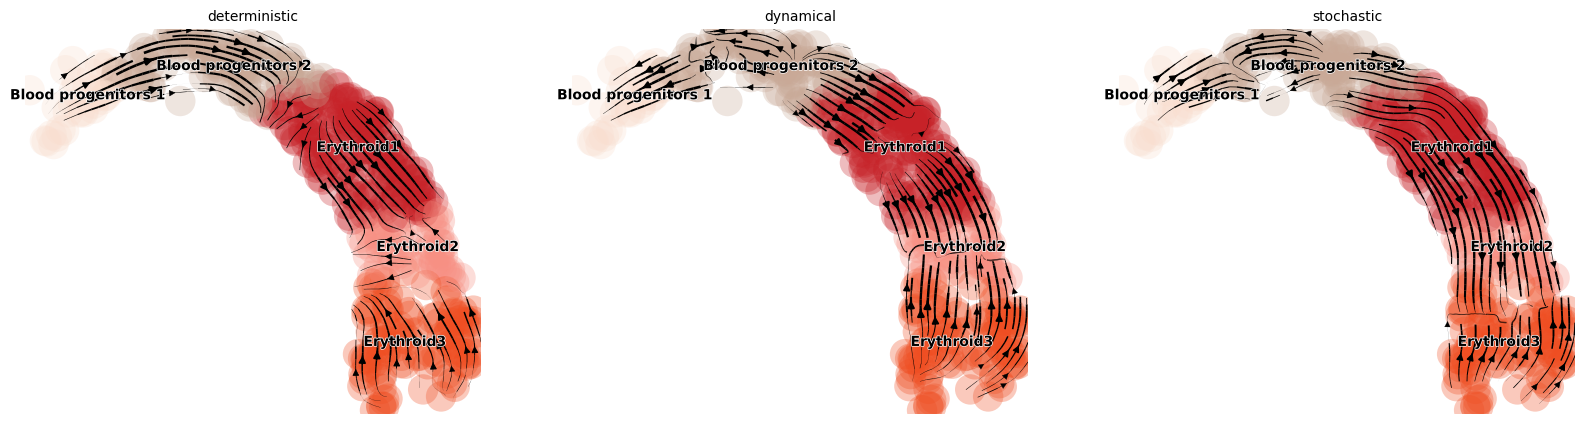

In [10]:
adata = scv.read("./tmp/corrected_erythroid_lineage_tmp_review_scanpy.h5ad")
plot_scvelo_all_mode(adata, cluster_key)

===== deterministic =====
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== dynamical =====
recovering dynamics (using 1/12 cores)


  0%|          | 0/189 [00:00<?, ?gene/s]

    finished (0:01:06) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== stochastic =====
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


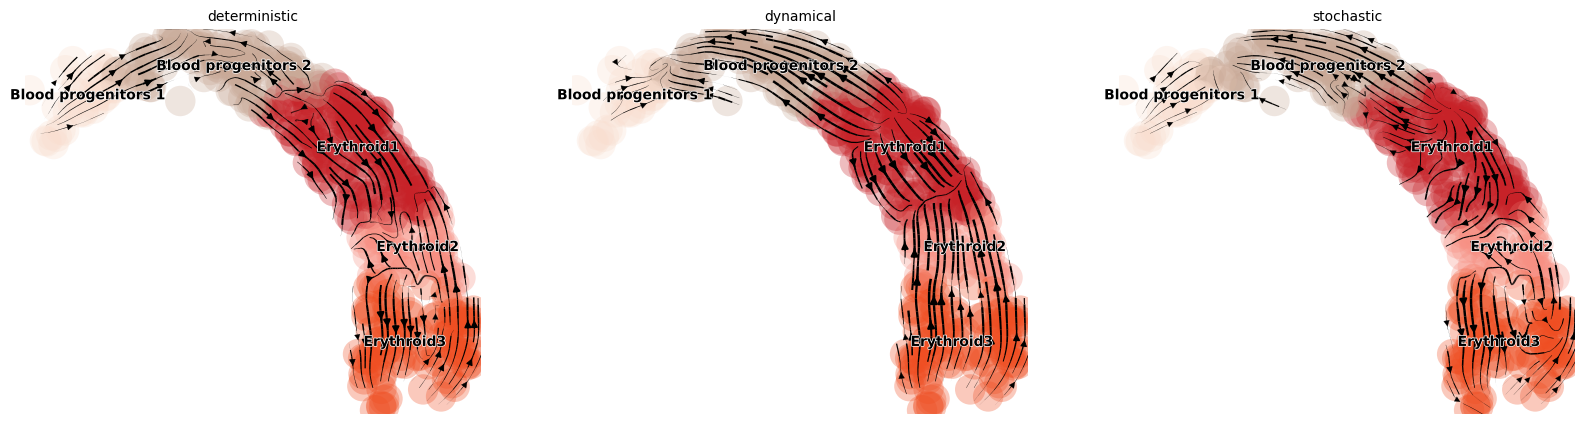

In [11]:
adata = scv.read("./tmp/corrected_erythroid_lineage_tmp_review_scvelo.h5ad")
plot_scvelo_all_mode(adata, cluster_key)

===== deterministic =====
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== dynamical =====
recovering dynamics (using 1/12 cores)


  0%|          | 0/691 [00:00<?, ?gene/s]

    finished (0:04:35) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== stochastic =====
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


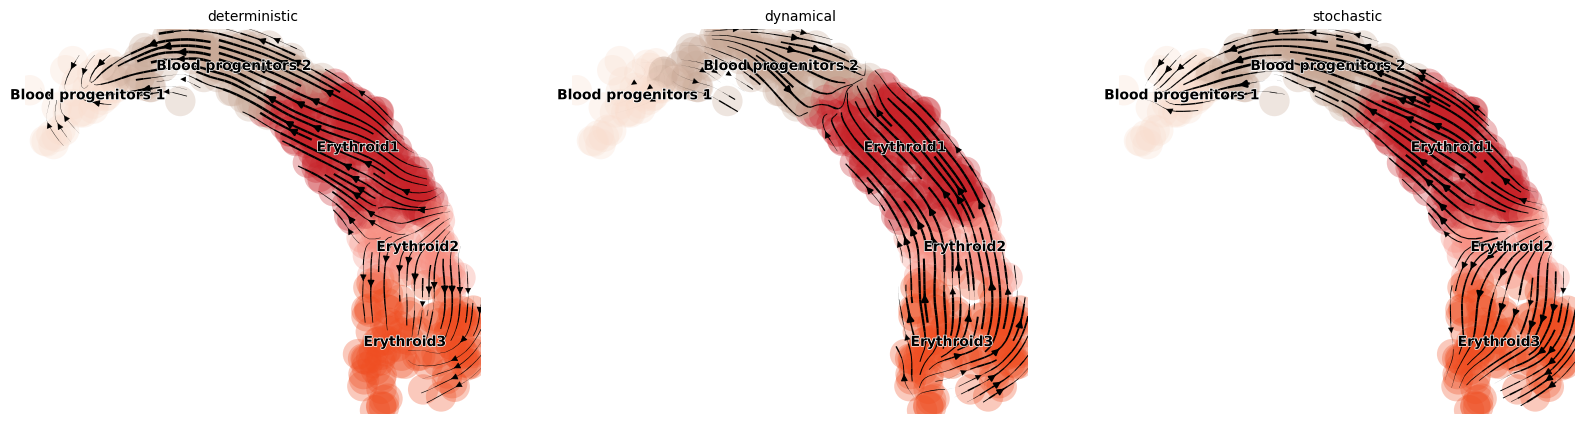

In [12]:
adata = scv.read("./tmp/corrected_erythroid_lineage_tmp_latentvelo_scanpy.h5ad")
plot_scvelo_all_mode(adata, cluster_key)

===== deterministic =====
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== dynamical =====
recovering dynamics (using 1/12 cores)


  0%|          | 0/819 [00:00<?, ?gene/s]

    finished (0:04:55) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
===== stochastic =====
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


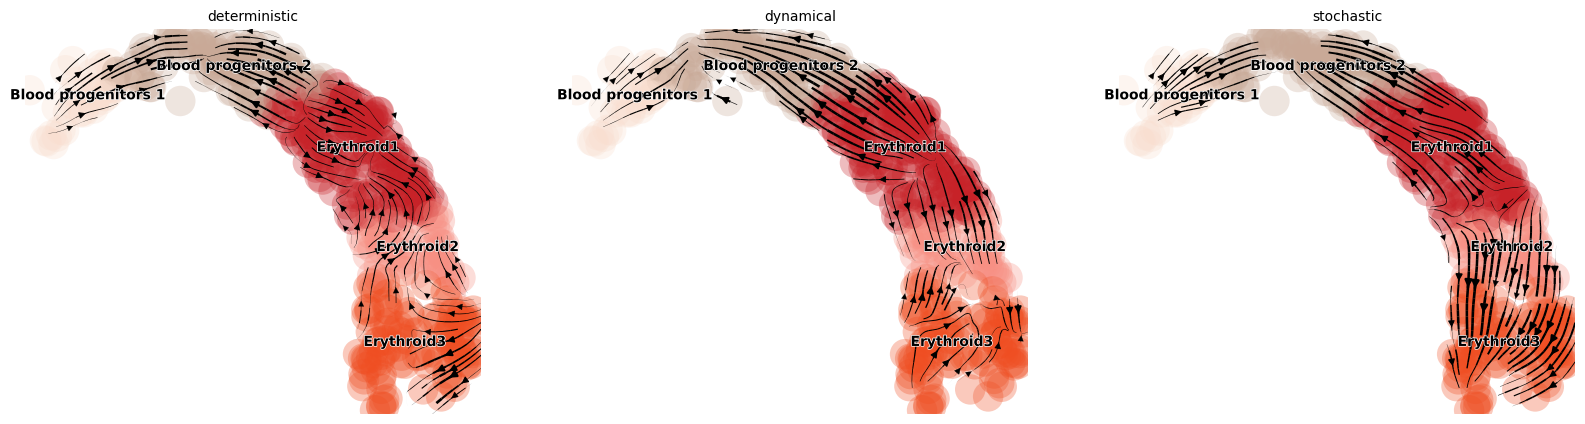

In [13]:
adata = scv.read("./tmp/corrected_erythroid_lineage_tmp_latentvelo_scvelo.h5ad")
plot_scvelo_all_mode(adata, cluster_key)

对于当前数据集，从目前的结果上看来，效果可以使用scvelo的预处理，比较两种批次整合使用，最后使用随机模式展示。说明，两种处理批次的思路能够正确恢复部分细胞的速率方向， 单上整体速率与背景差距还很远。